In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
if "CI" not in os.environ:
    df = pl.read_parquet(
        "https://osf.io/gk2ty/download",
        use_pyarrow=True,
    )


In [3]:
if "CI" not in os.environ:
    df = df.with_columns(
        Components=pl.col("Task").replace_strict(
            {
                "AND": 2,
                "ANDNOT": 3,
                "NAND": 1,
                "NOR": 4,
                "NOT": 1,
                "OR": 3,
                "ORNOT": 2,
                "XOR": 4,
                "EQUALS": 5,
            },
        ),
    )


In [4]:
if "CI" not in os.environ:
    df = df.with_columns(
        (
            pl.col("Components")
            * pl.col("has task")
        ).max().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("max components"),
    )


In [5]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("SLIP_INSERTION_BOOL_MASK").any().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("SLIP_INSERTION_BOOL_MASK any"),
    )


In [6]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Is Task Coding Site").any().over(
            ["Treatment", "Run ID", "Generation Born", "Site"],
        )
        .alias("is any coding site"),
    )


In [7]:
if "CI" not in os.environ:
    df = df.with_columns(
        (pl.col("delta has task") == 1).any().over(
            ["Treatment", "Run ID", "Generation Born"],
        )
        .alias("gained any task"),
    )


In [8]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Is Task Coding Site Delta").sum().over(
            ["Treatment", "Run ID", "Generation Born"],
        )
        .alias("is task coding site delta sum"),
    )


In [9]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("has task").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Site"],
        )
        .alias("num tasks has"),
    )


In [10]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("is any coding site").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Task",],
        ).alias("num coding sites"),
    )


In [11]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("SLIP_INSERTION_BOOL_MASK").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Task",],
        ).alias("slip size"),
    )


In [12]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("SLIP_INSERTION_BOOL_MASK").mean().over(
            ["Treatment", "Run ID", "Generation Born", "Task",],
        ).alias("slip frac"),
    )


In [13]:
if "CI" not in os.environ:
    dfx = df.group_by(
        ["Treatment", "Run ID", "Generation Born", "num tasks has", "num coding sites", "is task coding site delta sum", "SLIP_INSERTION_BOOL_MASK any", "max components", "gained any task", "slip size",  "slip frac"],
    ).agg(
        (
            (pl.col("delta has task") == 1).any() * 2
            + (pl.col("delta has task") == -1).any()
        ).replace_strict(
            {
                0: "No change",
                1: "Task loss",
                2: "Task gain",
                3: "Task gain and loss",
            },
        )
        .alias("task change"),
    )
    dfx.write_parquet("/tmp/robustness.pqt")
else:
    dfx = pl.read_parquet("https://osf.io/2jst4/download")


In [14]:
dfx


Treatment,Run ID,Generation Born,num tasks has,num coding sites,is task coding site delta sum,SLIP_INSERTION_BOOL_MASK any,max components,gained any task,slip size,slip frac,task change
cat,cat,u16,u32,u32,i64,bool,i64,bool,u32,f64,str
"""Baseline-Treatment""","""run_1554""",404,7,28,-1,false,4,false,0,0.0,"""No change"""
"""Baseline-Treatment""","""run_1557""",4238,6,30,2,false,3,false,0,0.0,"""No change"""
"""Slip-duplicate""","""run_1605""",720,7,70,0,false,4,false,0,0.0,"""No change"""
"""Baseline-Treatment""","""run_1546""",297,3,15,0,false,2,false,0,0.0,"""No change"""
"""Baseline-Treatment""","""run_1548""",3028,5,43,28,false,3,false,0,0.0,"""No change"""
…,…,…,…,…,…,…,…,…,…,…,…
"""Baseline-Treatment""","""run_1541""",5661,6,29,0,false,3,false,0,0.0,"""No change"""
"""Slip-duplicate""","""run_1617""",698,9,98,-6,false,5,false,0,0.0,"""No change"""
"""Baseline-Treatment""","""run_1547""",3669,7,29,0,false,4,false,0,0.0,"""No change"""


teeplots/col=num-tasks-has+hue=task-change+kind=box+viz=catplot+x=treatment+y=num-coding-sites+ext=.pdf


teeplots/col=num-tasks-has+hue=task-change+kind=box+viz=catplot+x=treatment+y=num-coding-sites+ext=.png


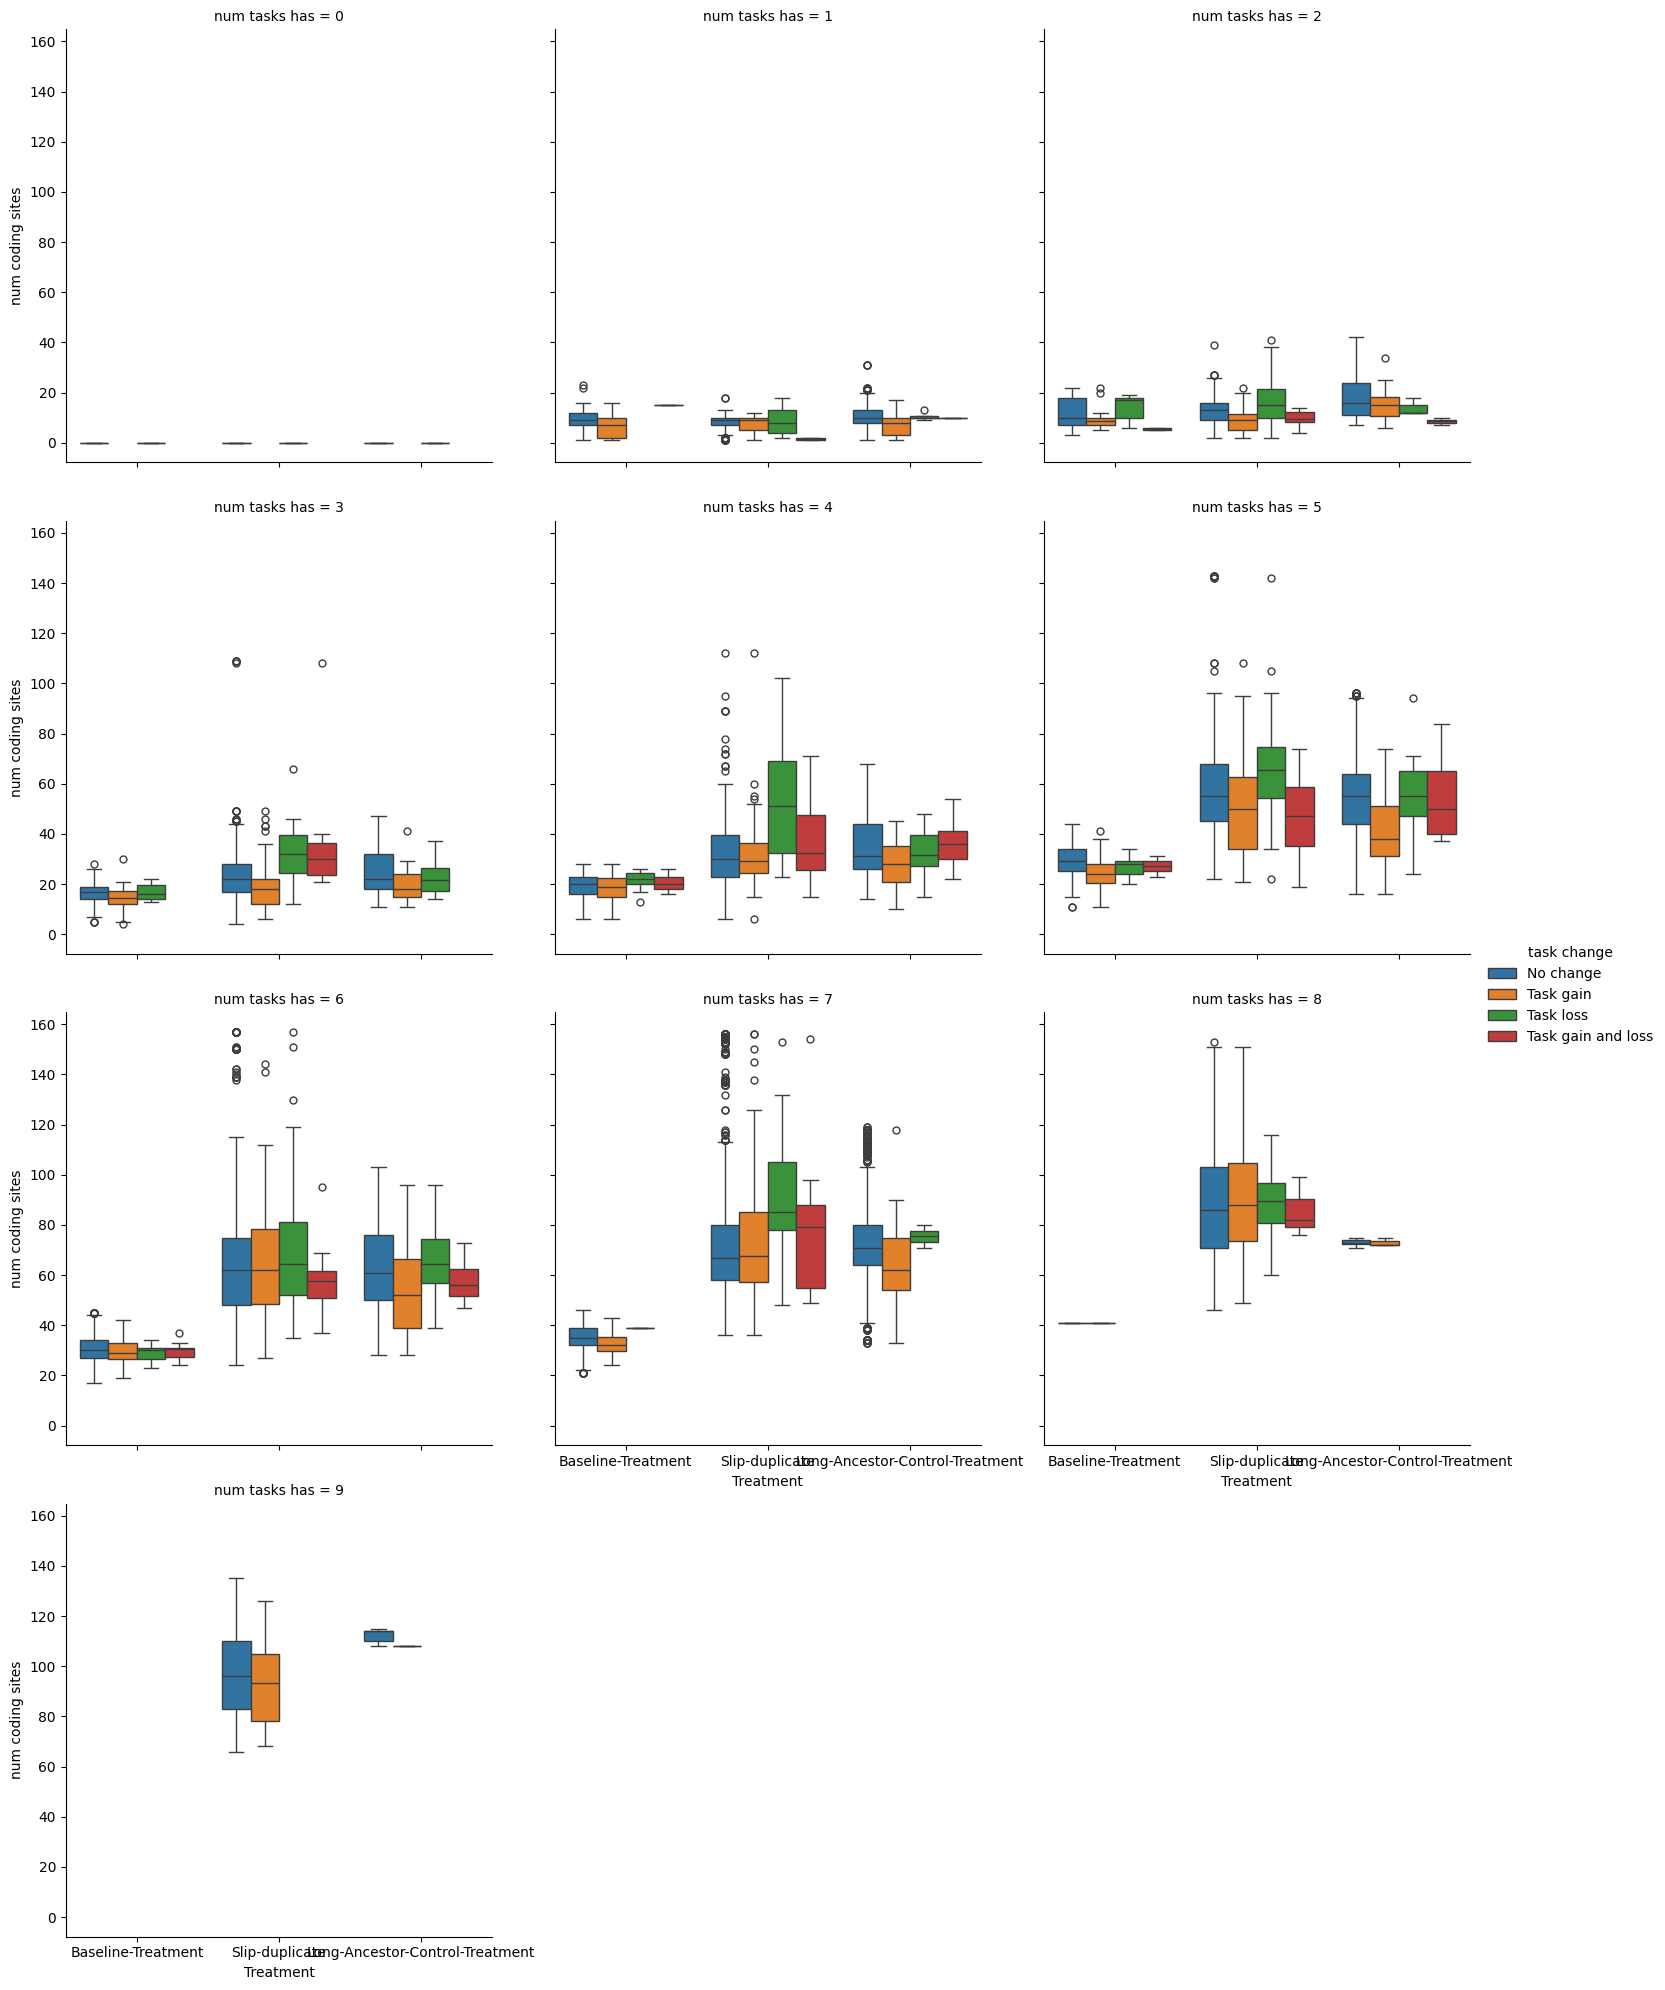

In [15]:
tp.tee(
    sns.catplot,
    hue="task change",
    y="num coding sites",
    x="Treatment",
    kind="box",
    col="num tasks has",
    data=dfx.to_pandas(),
    col_wrap=3,
)


teeplots/col=treatment+hue=task-change+kind=bar+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/col=treatment+hue=task-change+kind=bar+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.png


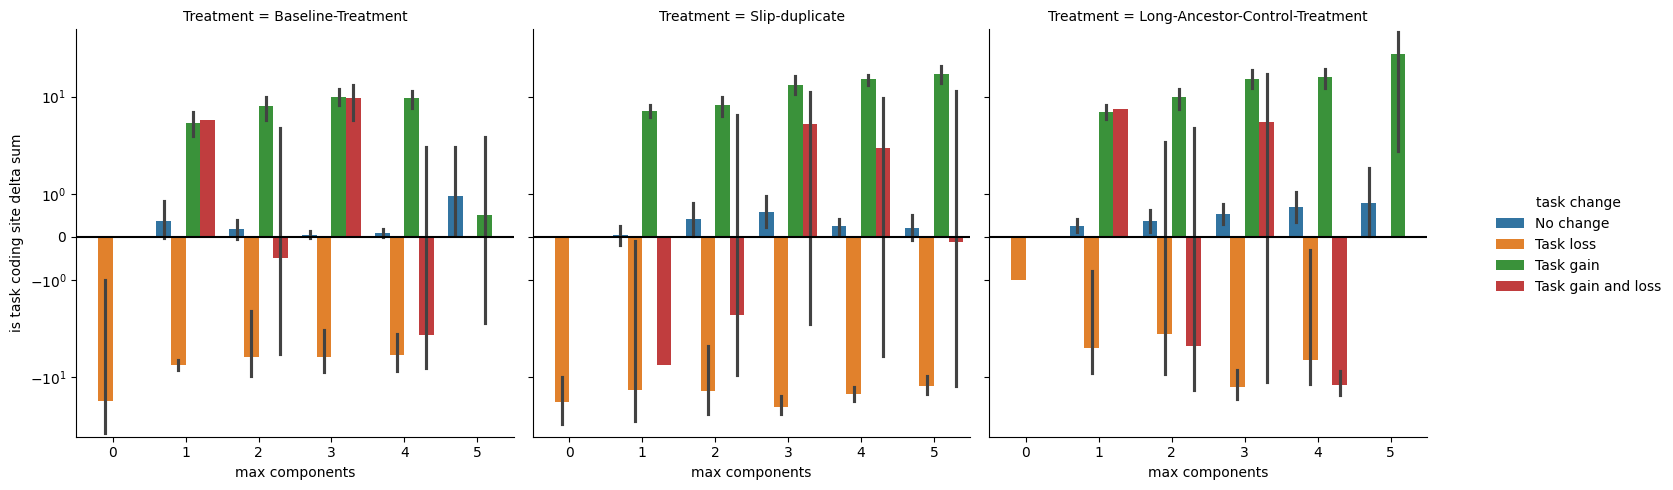

teeplots/col=treatment+hue=task-change+kind=bar+row=slip-insertion-bool-mask-any+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/col=treatment+hue=task-change+kind=bar+row=slip-insertion-bool-mask-any+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.png


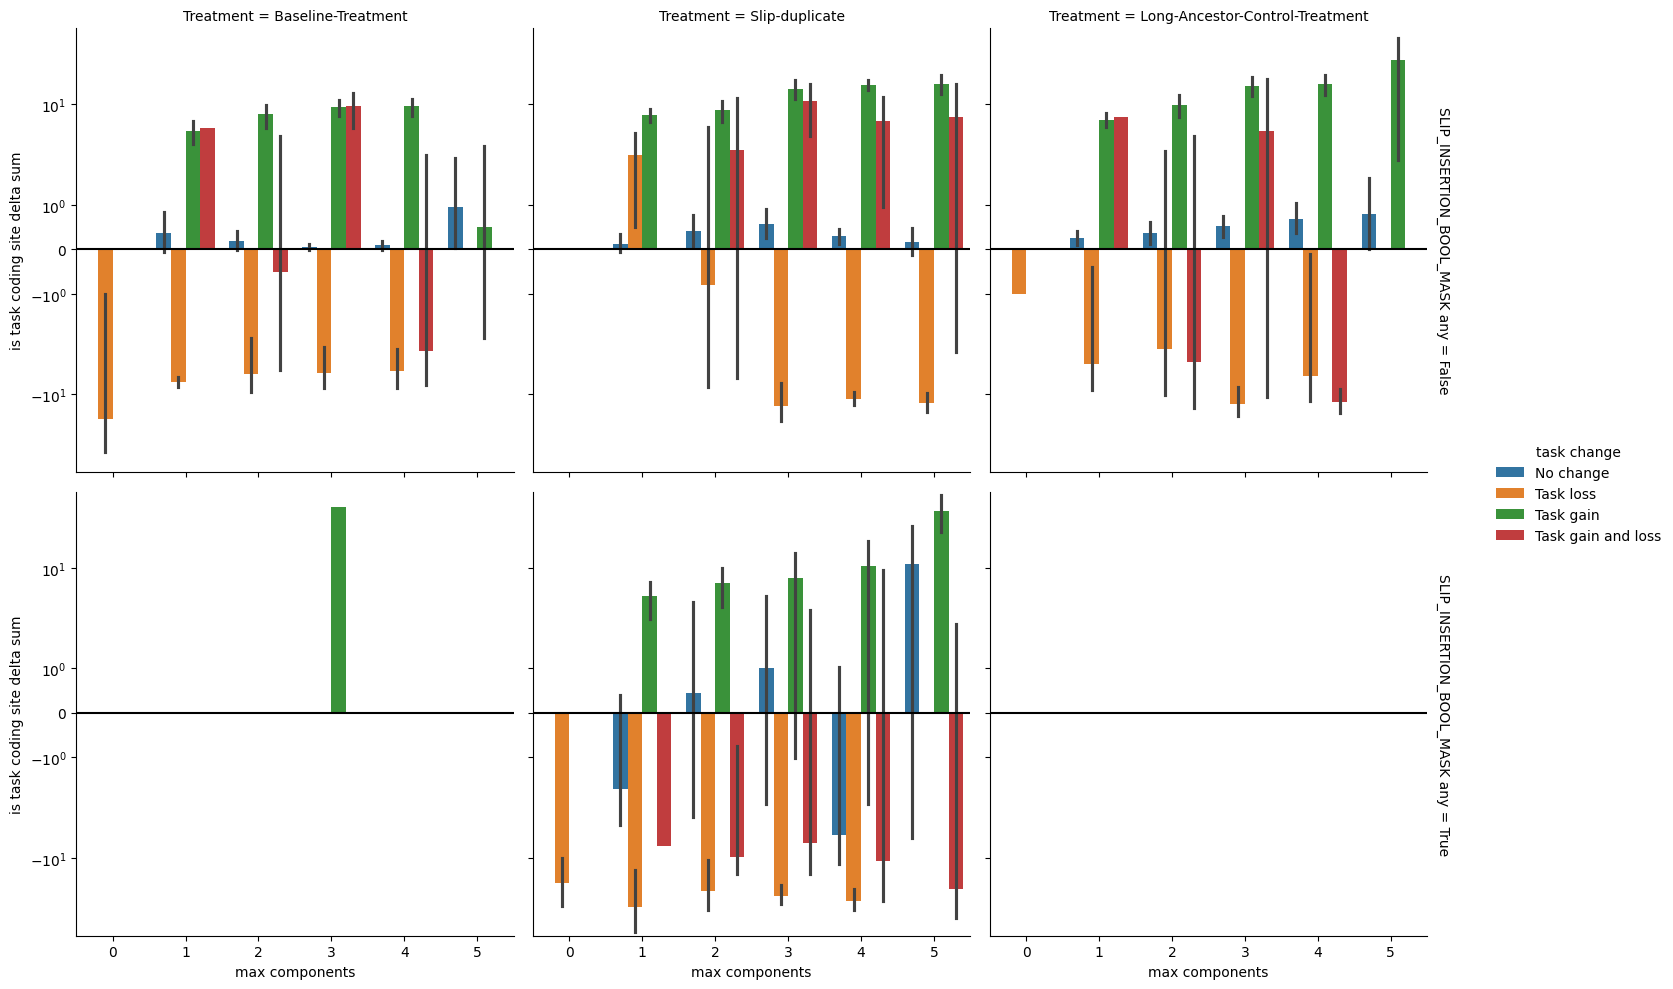

In [16]:
for row in None, "SLIP_INSERTION_BOOL_MASK any":
    saveit, g = tp.tee(
        sns.catplot,
        hue="task change",
        y="is task coding site delta sum",
        col="Treatment",
        kind="bar",
        x="max components",
        margin_titles=True,
        data=dfx.to_pandas(),
        row=row,
        teeplot_callback=True,
    )
    for ax in g.axes.flat:
        ax.axhline(0, color="black")
        ax.set_yscale("symlog")

    saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.png


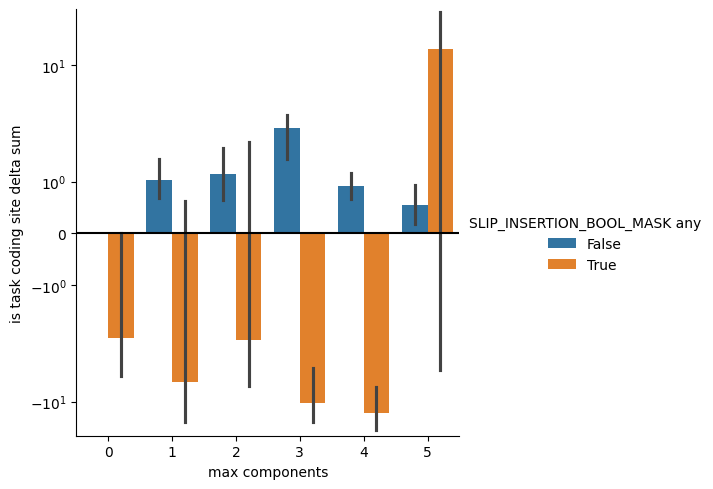

In [17]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    x="max components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/estimator=median+hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.pdf
teeplots/estimator=median+hue=slip-insertion-bool-mask-any+kind=bar+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.png


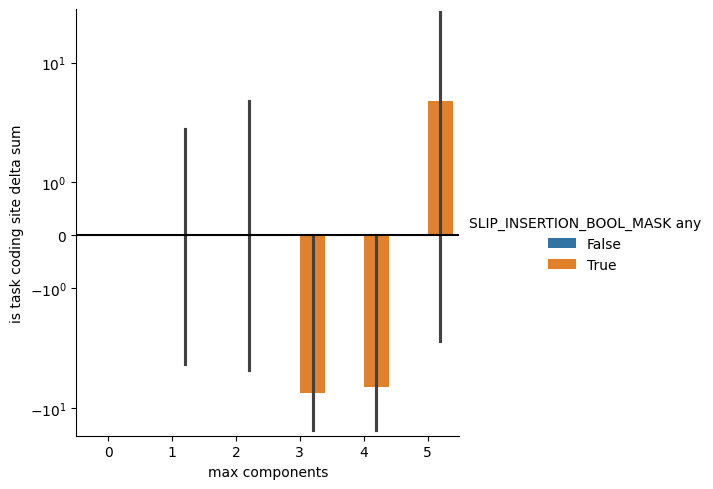

In [18]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="bar",
    x="max components",
    estimator="median",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.pdf


teeplots/hue=slip-insertion-bool-mask-any+kind=strip+viz=catplot+x=max-components+y=is-task-coding-site-delta-sum+ext=.png


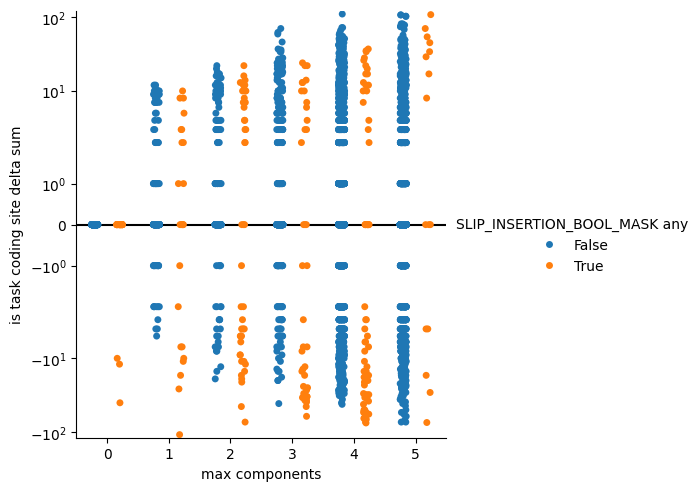

In [19]:
saveit, g = tp.tee(
    sns.catplot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    y="is task coding site delta sum",
    kind="strip",
    dodge=True,
    x="max components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas(),
    teeplot_callback=True,
)
for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.set_yscale("symlog")

saveit()


teeplots/col=task-change+hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+row=treatment+stat=count+viz=displot+x=max-components+ext=.pdf


teeplots/col=task-change+hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+row=treatment+stat=count+viz=displot+x=max-components+ext=.png


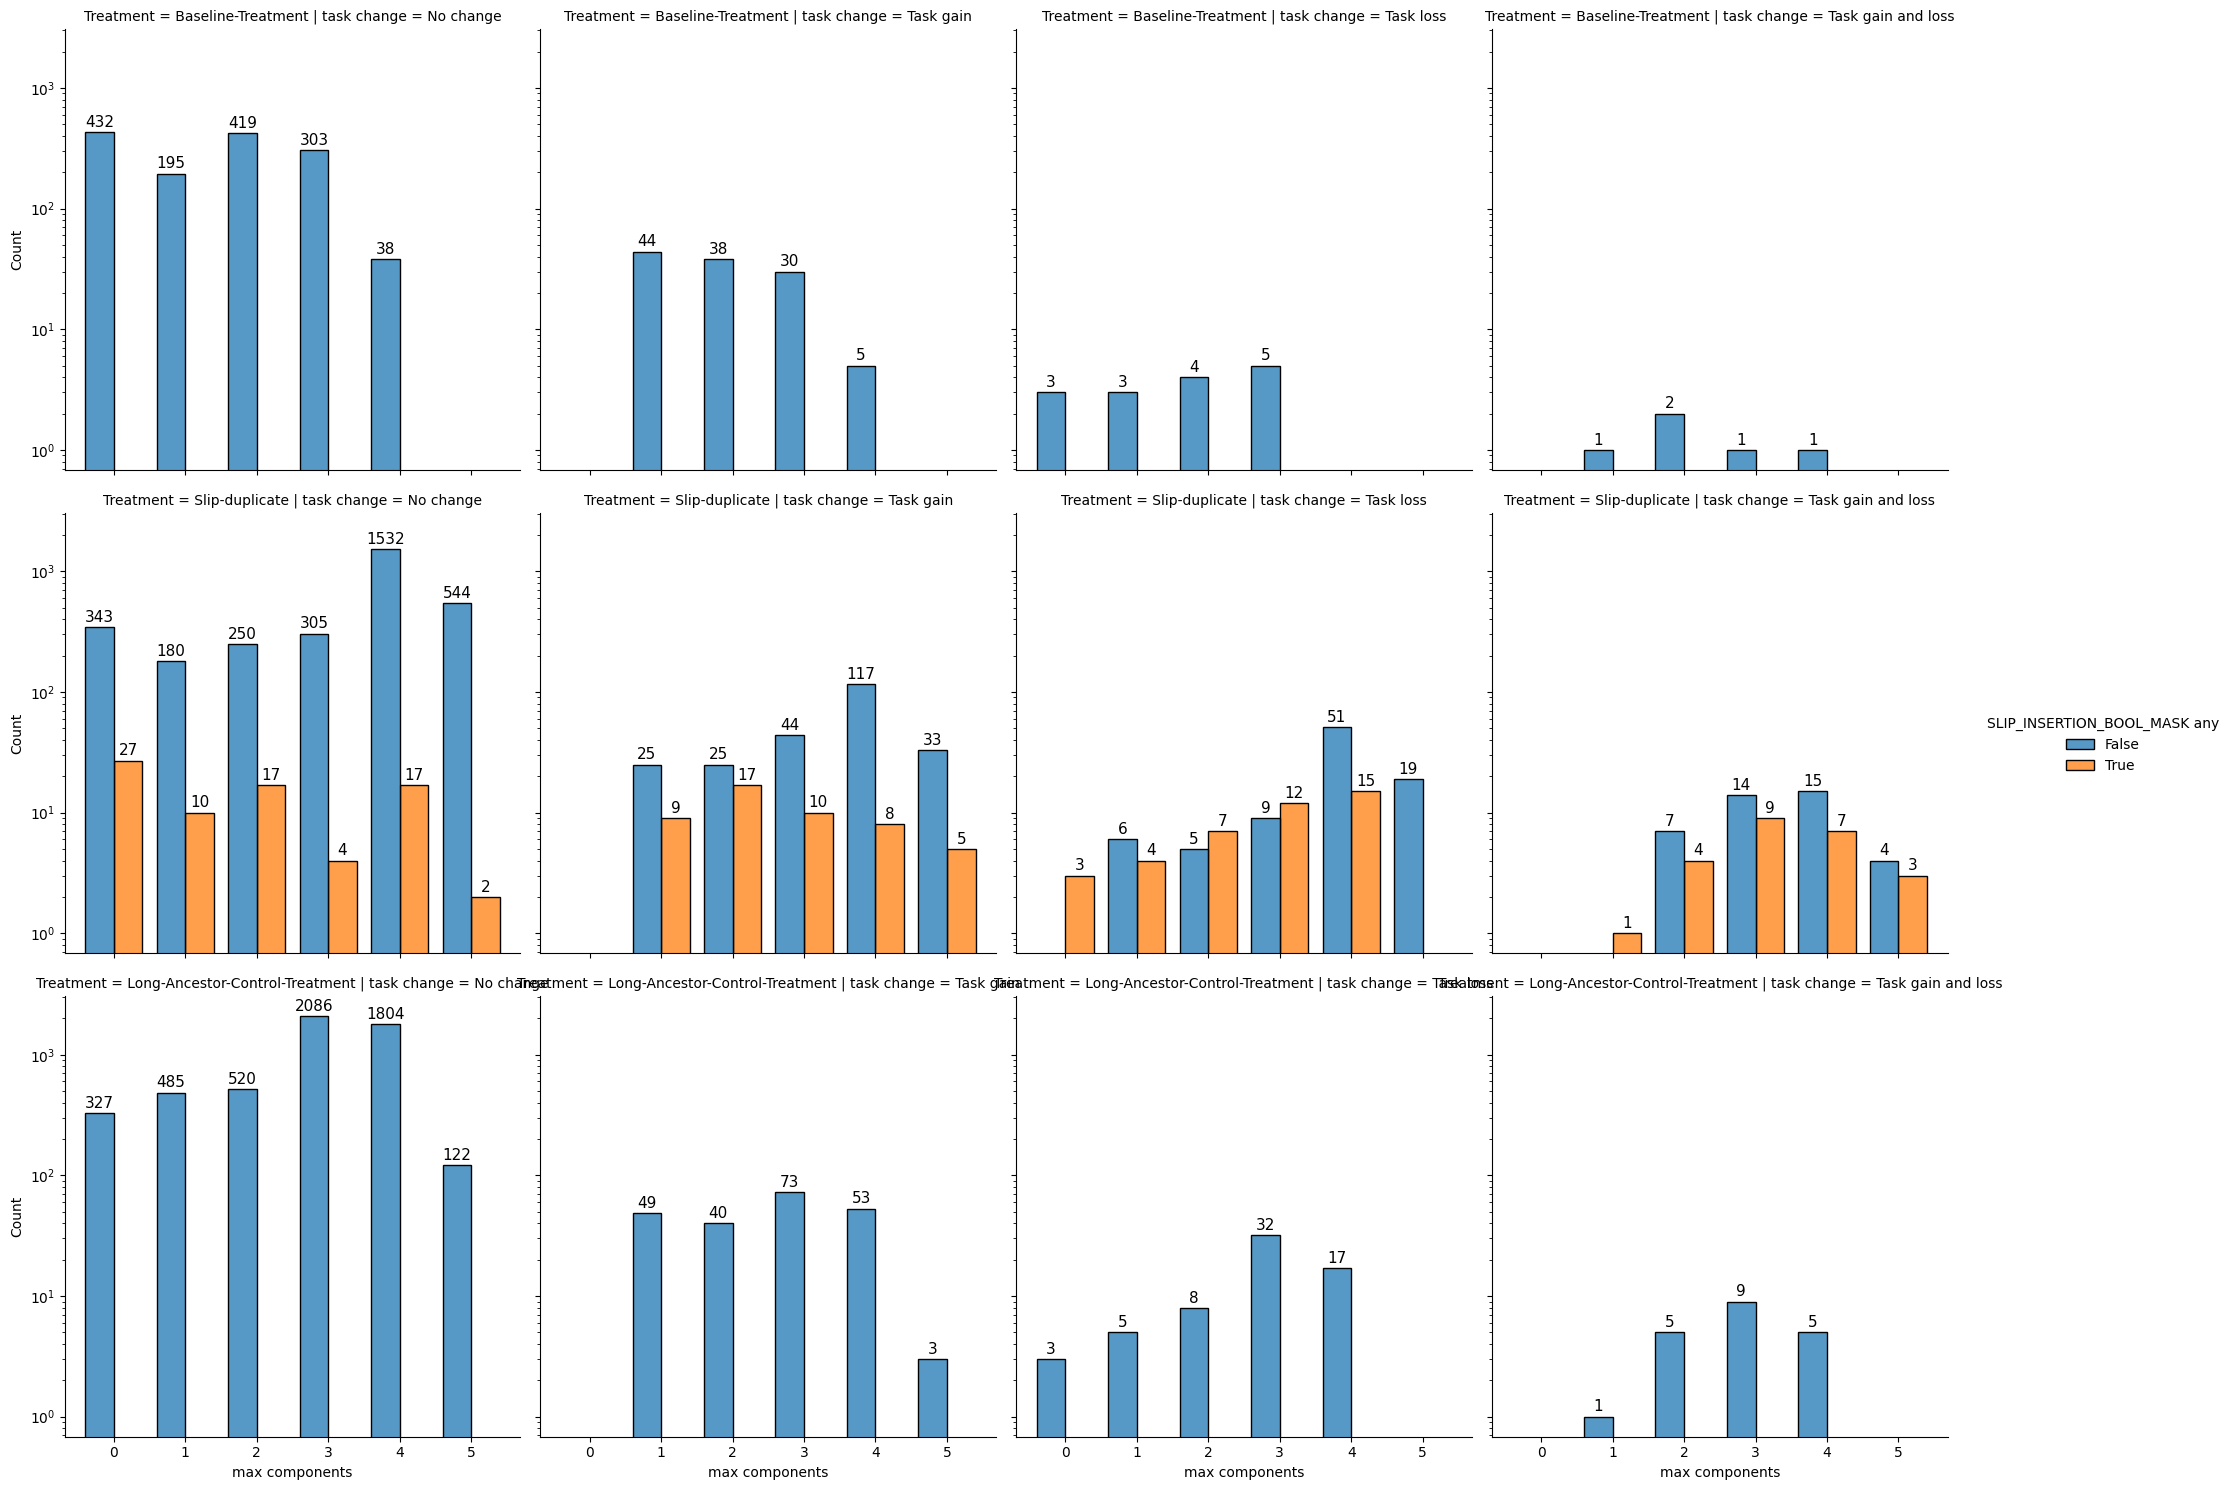

In [20]:
saveit, g = tp.tee(
    sns.displot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    kind="hist",
    col="task change",
    row="Treatment",
    x="max components",
    data=dfx.filter(
        pl.col("Generation Born") < 700,
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,

)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()


teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=max-components+ext=.pdf
teeplots/hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=max-components+ext=.png


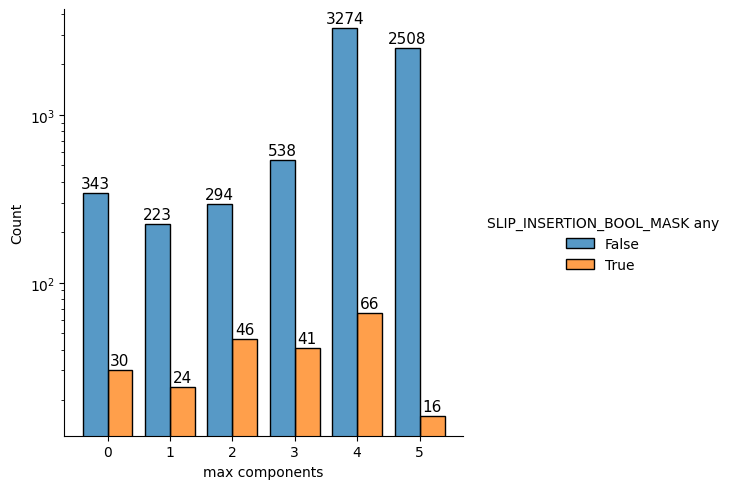

In [21]:
saveit, g = tp.tee(
    sns.displot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    kind="hist",
    x="max components",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,

)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )

saveit()


teeplots/col=gained-any-task+hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=max-components+ext=.pdf


teeplots/col=gained-any-task+hue=slip-insertion-bool-mask-any+kind=hist+multiple=dodge+stat=count+viz=displot+x=max-components+ext=.png


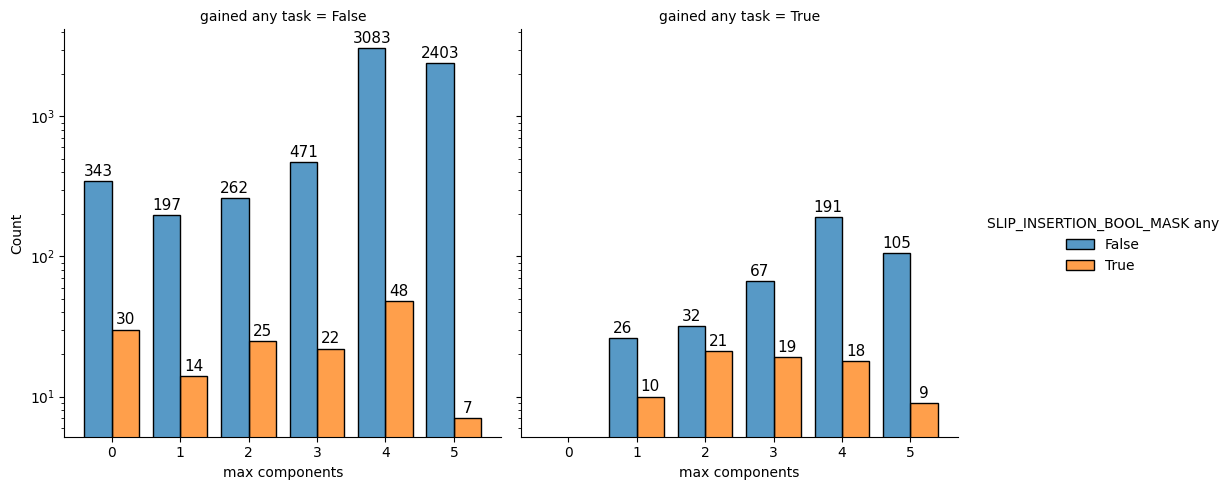

In [22]:
saveit, g = tp.tee(
    sns.displot,
    hue="SLIP_INSERTION_BOOL_MASK any",
    kind="hist",
    x="max components",
    col="gained any task",
    data=dfx.filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).to_pandas().astype(
        {"num tasks has": "category"},
    ),
    teeplot_callback=True,
    stat="count",
    multiple="dodge",
    shrink=0.8,
    discrete=True,

)
plt.yscale('log')

# add count labels
# adapted from https://stackoverflow.com/a/55319634/17332200
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(
            text=f"{p.get_height():1.0f}",
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xycoords='data',
            ha='center',
            va='center',
            fontsize=11,
            color='black',
            xytext=(0,7),
            textcoords='offset points',
            clip_on=True,                   # <---  important
        )
    # ax.axhline(0.05, color="white", linestyle="--")
saveit()
